In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from Code import Algo2
from Code import ULA
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import importlib
importlib.reload(Algo2)

<module 'Code.Algo2' from '/home/nurlan/Documents/_Research/VR-MCMC/Code/Algo2.py'>

In [3]:
dim = 1
h = 0.1
   
def f_grad(x):
    a = 1 / np.sqrt(2)
    return x-a+2*a/(1 + np.exp(2* (x * a)))


### Structure of $\bar{Q}_{l,n}(x)$

$$\bar{Q}_{l,n}^N (x) = \mathbb{E} \left [\sum_{p = l}^{N+n} \frac{1}{n} f(X_p) | X_l = x \right] \quad \forall l = N+1, \dots, N+n$$

In order, to approximate functions $\bar{Q}_{l,n}^N(x)$, for all $l$ I generated trajectories started from each point of the grid and estimated the functions. Particularly:

we have grid on $I = \left[-5,  5 \right]$

for each point $x \in I$, for each $l$ I generated $N_{train} = 100 $ trajectories of length $n+N-l$:

$$X^{x, (i)}_0 = x$$

$$X^{x, (i)}_p = X_{p-1}^{x,(i)} - h  \mu( X_{p-1}^{x,(i)}) + \sqrt{h} Z_p^{(i)}$$

$$ \forall p = 1, \dots, n \text{ and }  i = 1, \dots , N_{train}$$

Then I estimate:
$$\bar{Q}_{l, n}^N (x) = \frac{1}{N_{train}} \sum_{i = 1}^{N_{train}}\sum_{p = 0}^{n-l} \frac{1}{n} X_p^{x, (i)} \quad \forall x \in I$$

In [5]:
n = 250
N_train = 100

grid = np.arange(-10, 10, 0.4)

def q_l_by_grid(grid, l, n, N_train):
    np.random.seed(42)
    noise = np.random.randn(N_train, n-l)
    trajectories_on_grid = np.zeros((grid.shape[0], N_train, n-l))
    for j in range(N_train):
        trajectories_on_grid[:,j,0] = grid
    for i in range(grid.shape[0]):
        for j in range(N_train):
            for m in range(1,n-l):
                trajectories_on_grid[i,j,m] = trajectories_on_grid[i,j,m-1] - h/2 * f_grad(trajectories_on_grid[i,j,m-1]) \
                    + np.sqrt(h) * noise[j,m]
    return ((trajectories_on_grid).sum(axis = 2) / n).mean(axis = 1)    

In [6]:
Q_grid = np.zeros((n, grid.shape[0]))
for l in tqdm(range(n)):
    Q_grid[l] = q_l_by_grid(grid, l, n, N_train)

100%|██████████| 250/250 [18:00<00:00,  4.32s/it]


In [8]:
np.save('Q_grid.npy', Q_grid)

In [9]:
# Q_grid = np.load('Q_grid.npy')

#### Some plots for $\bar{Q}_{l,n} (x)$ for $l \in \left\{1, 20, 50, 100,150,200, 230, 250 \right\}$ and $n = 250$

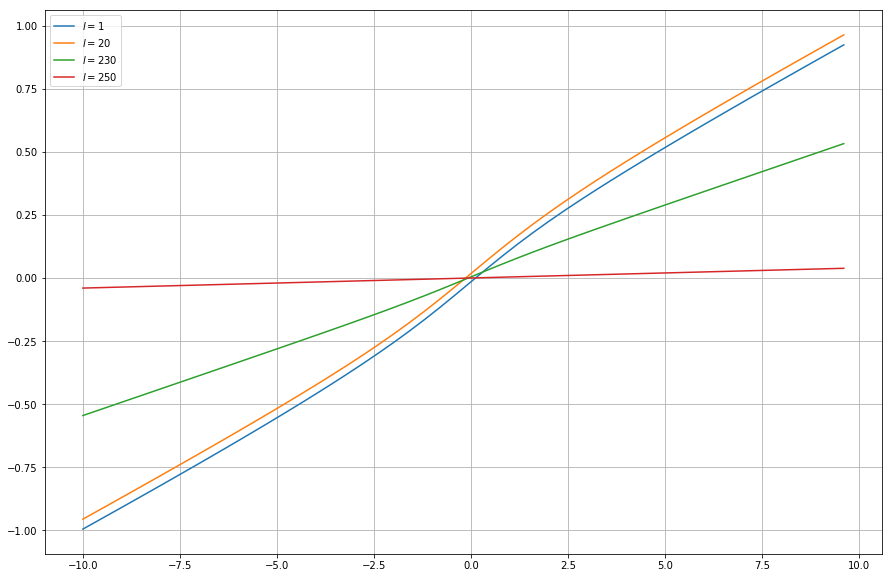

In [10]:
plt.figure(figsize=(15,10))

for l in [0,19,229,249]:
    plt.plot(grid, Q_grid[l], label = r"$l = {}$".format(l+1))
plt.legend()
plt.grid()
# plt.xlim(-1,1)
plt.show()

#### Define function $\tilde{\bar{Q}}_{l,n}(x)$, which finds $i$ such that: $x_i < x < x_{i+1}$ where $x_i, x_{i+1} \in I$

$$\tilde{\bar{Q}}_{l,n}(x) = \frac{\bar{Q}_{l,n}(x_i) + \bar{Q}_{l,n}(x_{i+1})}{2}$$

In [38]:
def Q_l(grid, Q_grid, x, l):
    pos = np.searchsorted(grid, x)
    if pos > 0:
        return Q_grid[l, pos-1:pos+1].mean()
    else:
        return 0

### Comparison with approximation using regression on pregenerated train trajectories

In [15]:
np.random.seed(2342)
X, G, Z = ULA.ULA_with_burnin(d=dim, step=h, burn_in=10000, n=1000000,f_grad=f_grad)

In [16]:
def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

In [17]:
np.random.seed(123)

XX, GG, ZZ = ULA.generate_train_trajectories(X, N_train=2000,d = dim, step = h, n = n, f_grad=f_grad)

In [18]:
import importlib
importlib.reload(Algo2)

<module 'Code.Algo2' from '/home/nurlan/Documents/_Research/VR-MCMC/Code/Algo2.py'>

In [22]:
deg = 1
Betas, degrees = Algo2.Q_l_fit(XX, f_target="sum", max_deg = deg)

100%|██████████| 250/250 [00:02<00:00, 112.98it/s]


In [23]:
def Q_l_predict(x, l, Betas, max_deg):
    poly = PolynomialFeatures(max_deg)
    x_pol = poly.fit_transform(np.array(x).reshape(1,-1))
    beta = Betas[l]
    return (x_pol @ beta)

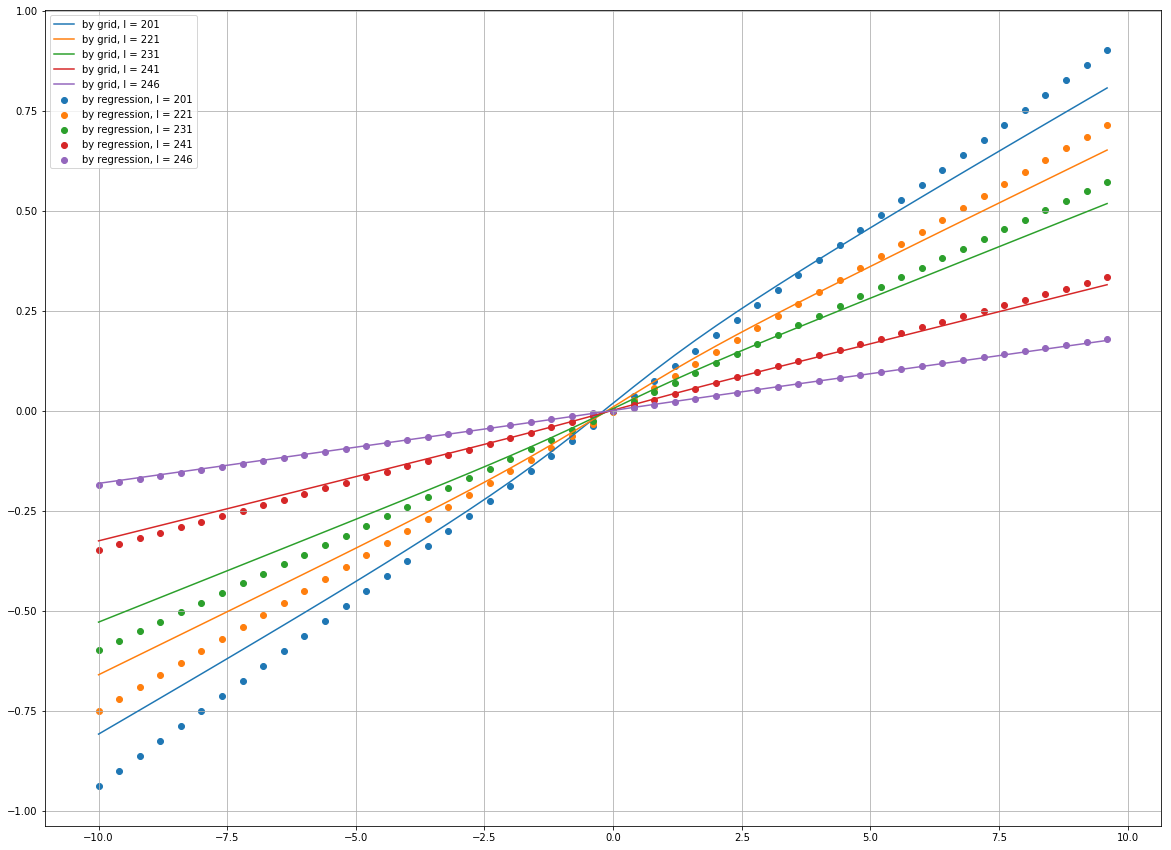

In [24]:
plt.figure(figsize=(20,15))
q_l_predict_plot = np.zeros_like(grid)

for l in [200, 220, 230, 240, 245]:
    for i in range(grid.shape[0]):
        q_l_predict_plot[i] = Q_l_predict(grid[i], l, Betas, deg) 
    plt.plot(grid, Q_grid[l], label = "by grid, l = {}".format(l+1))
    plt.scatter(grid, q_l_predict_plot, label = "by regression, l = {}".format(l+1), )
plt.legend()
plt.grid()
plt.show()

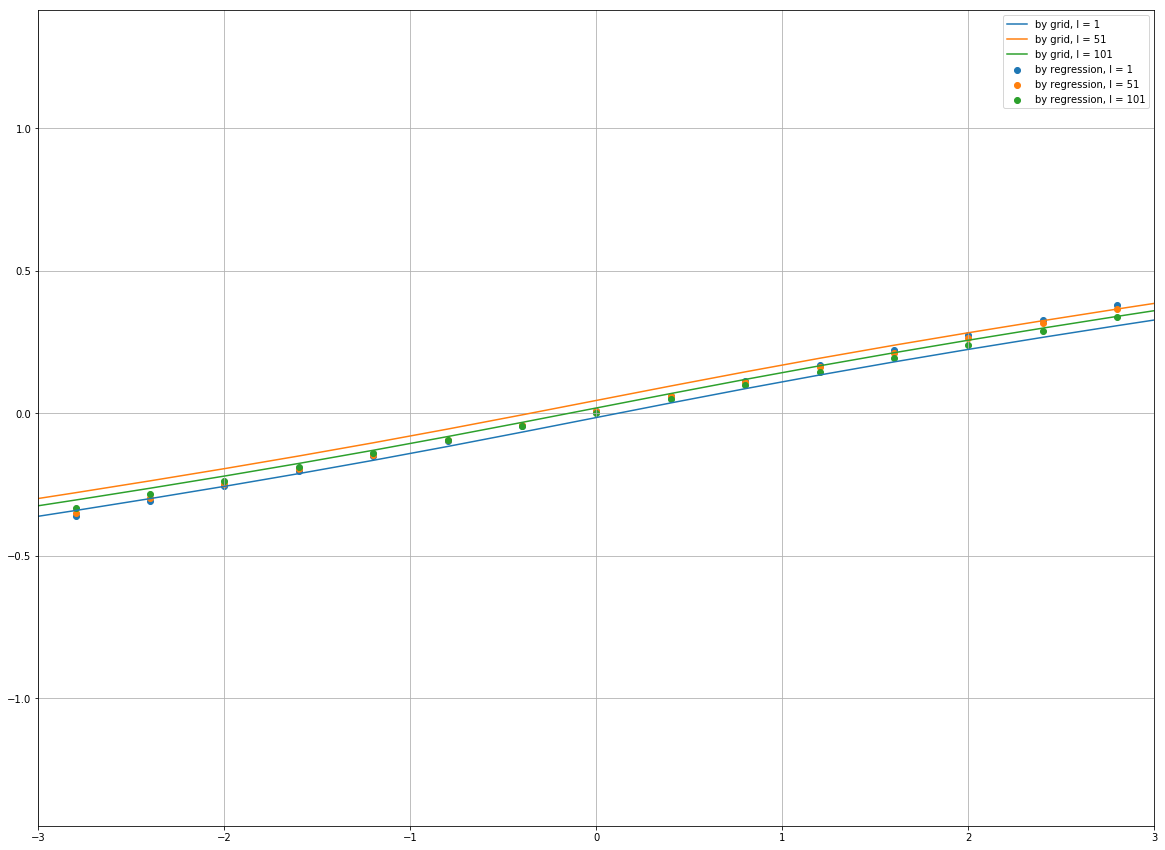

In [26]:
plt.figure(figsize=(20,15))
q_l_predict_plot = np.zeros_like(grid)

for l in [0, 50, 100]:
    for i in range(grid.shape[0]):
        q_l_predict_plot[i] = Q_l_predict(grid[i], l, Betas, deg) 
    plt.plot(grid, Q_grid[l], label = "by grid, l = {}".format(l+1))
    plt.scatter(grid, q_l_predict_plot, label = "by regression, l = {}".format(l+1), )
plt.legend()
plt.xlim(-3,3)
plt.grid()
plt.show()

## "Ground truth" result for dimension 1
####  Suppose we have markov chain with gaussian mixture distribution:

$X_1, X_2, \dots, X_n$

where $n$ = 500

$f(x) = x$

$\gamma_i = h$

In [27]:
traj, traj_grad, traj_noise = ULA.ULA_with_burnin(dim, h, 10000, n, f_grad)

### Step 1. 

Suppose we have estimation for $\bar{Q}_{l, n}(x) \quad \forall l $ on grid 

### Step 2

$$a_{l,n}^k(x) = \mathbb{E}_{\xi} \left[ \phi_k(\xi) \bar{Q}_{l,n} (x - h\mu(x) + \sqrt{h}\xi)\right]= \int_{-\infty}^{\infty} \phi_k(y) \bar{Q}_{l,n} (x - h\mu(x) + \sqrt{h}y) \varphi(y) dy$$

where $$\varphi(y) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{y^2}{2}}$$

Integration by Monte Carlo:

Generate $\xi_i \sim \mathcal{N}(0,1)$ for $i = 1, \dots, n$

In [28]:
np.random.seed(123)
N_test = 50
XX_test, GG_test, ZZ_test = ULA.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad)

In [80]:
def a_lk_mc(x, x_grad, l, k, n_xi):
    xi = np.random.randn(n_xi)
    a_lk = np.zeros_like(xi)
    for i in range(xi.shape[0]):
        tmp = (x - h/2 * x_grad + np.sqrt(h) * xi[i])[0]
        a_lk[i] = Q_l(grid, Q_grid, tmp, l) * Algo2.H(k,xi[i])
    return a_lk.mean()

In [86]:
a_lk_mc(XX[2, 0], GG[2,0], 1, 1, 100000 )

0.03474619882551631

In [82]:
Algo2.a_lk(XX[2], GG[2], 1, np.array([1], dtype=np.int16),h, degrees, Betas)

0.041130587012421706

In [89]:
def M_bias_gt(traj, traj_grad, traj_noise, n_xi = 1000):
    S = 0
    for k in range (1, 2):
        for i in range(1,traj.shape[0]):
            S = S + a_lk_mc(traj[i-1], traj_grad[i-1], i, k, n_xi) *  Algo2.H(k,traj_noise[i])
    return S

In [91]:
M_bias_gt(XX[3], GG[3], ZZ[3])

array([-1.14305189])

In [92]:
local_weighted_estimator(XX[3])

-1.2121892341147509

In [93]:
Algo2.M_bias(np.array([1], dtype=np.int16), XX[3], GG[3], ZZ[3], h, degrees, Betas)

-1.3186739167206838